In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import shap

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')


In [2]:
DATA_PATH = '../data/df_clean_policy_level.csv'
df = pd.read_csv(DATA_PATH, index_col='PolicyID')

df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 14.0 to 22555.0
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TotalClaims         300 non-null    float64
 1   TotalPremium        300 non-null    float64
 2   Province            300 non-null    object 
 3   Gender              300 non-null    object 
 4   PostalCode          300 non-null    float64
 5   has_claim           300 non-null    bool   
 6   severity_per_claim  5 non-null      float64
 7   margin              300 non-null    float64
 8   gender_clean        300 non-null    object 
dtypes: bool(1), float64(5), object(3)
memory usage: 21.4+ KB


In [3]:
df_sev = df[df['has_claim'] == True].copy()


y_sev = df_sev['TotalClaims']

X_sev = df_sev.drop(columns=['TotalClaims', 'severity_per_claim', 'margin', 'has_claim'])


In [4]:
df_sev.isnull().sum()


TotalClaims           0
TotalPremium          0
Province              0
Gender                0
PostalCode            0
has_claim             0
severity_per_claim    0
margin                0
gender_clean          0
dtype: int64

In [11]:
cat_cols = X_sev.select_dtypes(include=['object']).columns.tolist() 
cat_cols = ['Province', 'Gender', 'gender_clean'] 

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough' 
)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_sev, y_sev, test_size=0.2, random_state=42)

In [13]:
pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


In [14]:
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])


In [15]:
pipe_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])


In [16]:
pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)
pipe_xgb.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [19]:

def evaluate_model(pipe, X_test, y_test):
    y_pred = pipe.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)  
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

for name, pipe in zip(['Linear Regression', 'Random Forest', 'XGBoost'], [pipe_lr, pipe_rf, pipe_xgb]):
    rmse, r2 = evaluate_model(pipe, X_test, y_test)
    print(f"{name}: RMSE = {rmse:.2f}, R2 = {r2:.2f}")

Linear Regression: RMSE = 54818.10, R2 = nan
Random Forest: RMSE = 508.77, R2 = nan
XGBoost: RMSE = 873.30, R2 = nan


c:\Users\hp\Documents\10-acad\week3\Risk-Analytics-Predictive-Modeling\.venv\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\hp\Documents\10-acad\week3\Risk-Analytics-Predictive-Modeling\.venv\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\hp\Documents\10-acad\week3\Risk-Analytics-Predictive-Modeling\.venv\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


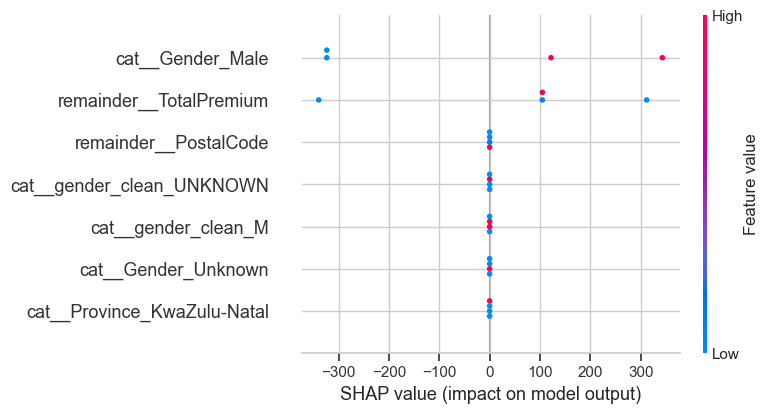

In [20]:
best_model = pipe_xgb.named_steps['regressor']

X_train_trans = pipe_xgb.named_steps['preprocessor'].transform(X_train)


explainer = shap.Explainer(best_model)
shap_values = explainer(X_train_trans)


shap.summary_plot(shap_values, X_train_trans, feature_names=pipe_xgb.named_steps['preprocessor'].get_feature_names_out())


In [23]:
df[['TotalPremium', 'TotalClaims', 'margin', 'severity_per_claim']].describe()


,TotalPremium,TotalClaims,margin,severity_per_claim
count,300.000000,300.000000,300.000000,5.000000
mean,9011.894544,17.090643,8994.803901,1025.438596
std,12233.113203,139.103299,12212.620585,392.292628
min,0.240327,0.000000,0.240327,850.000000
25%,2245.392823,0.000000,2245.392823,850.000000
50%,6188.127044,0.000000,6188.127044,850.000000
75%,11463.079759,0.000000,11385.076341,850.000000
max,132593.924926,1727.192982,132593.924926,1727.192982


In [25]:

df.groupby('Gender')['has_claim'].mean()


Gender
Female     0.043478
Male       0.020134
Unknown    0.007812
Name: has_claim, dtype: float64

In [26]:
df.groupby('Province')['has_claim'].mean()

Province
Gauteng          0.016393
KwaZulu-Natal    0.100000
Limpopo          0.000000
Mpumalanga       0.000000
North West       0.000000
Northern Cape    0.000000
Western Cape     0.000000
Name: has_claim, dtype: float64

In [27]:
df.groupby('PostalCode')['has_claim'].mean()



PostalCode
64.0      0.0
84.0      0.0
122.0     0.0
125.0     0.0
147.0     0.0
         ... 
8000.0    0.0
8005.0    0.0
8017.0    0.0
8020.0    0.0
8580.0    0.0
Name: has_claim, Length: 92, dtype: float64

In [28]:
df.groupby('PostalCode')['margin'].mean()

PostalCode
64.0      13530.188596
84.0      25379.066316
122.0     12677.494170
125.0     25949.655515
147.0      2246.969943
              ...     
8000.0    13233.163130
8005.0    22916.158107
8017.0       43.859649
8020.0     6685.872450
8580.0       43.859649
Name: margin, Length: 92, dtype: float64

In [29]:
df.groupby('PostalCode').size()


PostalCode
64.0      1
84.0      1
122.0     3
125.0     1
147.0     1
         ..
8000.0    1
8005.0    1
8017.0    1
8020.0    2
8580.0    1
Length: 92, dtype: int64

In [31]:
df.groupby('gender_clean')['has_claim'].mean()

gender_clean
F          0.043478
M          0.020134
UNKNOWN    0.007812
Name: has_claim, dtype: float64

In [ ]:
df.groupby('gender_clean')['margin'].mean()

gender_clean
F          13040.997056
M          10622.981063
UNKNOWN     6372.453591
Name: margin, dtype: float64

In [33]:
df.groupby('gender_clean').size()

gender_clean
F           23
M          149
UNKNOWN    128
dtype: int64

In [34]:
claim_counts = df[df['gender_clean'].isin(['F', 'M'])].groupby('gender_clean')['has_claim'].value_counts().unstack(fill_value=0)
print(claim_counts)


has_claim     False  True 
gender_clean              
F                22      1
M               146      3


In [35]:
margin_F = df[df['gender_clean'] == 'F']['margin']
margin_M = df[df['gender_clean'] == 'M']['margin']

print("Margin F:", margin_F.values)
print("Margin M:", margin_M.values)


Margin F: [1.51867402e+02 1.16104520e+03 2.59496555e+04 1.87657720e+03
 2.59422568e+03 1.72413282e+04 1.29688755e+04 8.62510421e+03
 3.82814456e+04 4.38596491e+01 3.70537288e+04 4.38596491e+01
 1.79307631e+04 6.18723908e+03 1.35300463e+04 1.07754381e+04
 1.02686490e+04 9.80401675e+03 8.13850449e+04 4.38596491e+01
 4.38596491e+01 2.54793727e+03 1.43450585e+03]
Margin M: [9.15785877e+02 1.69298102e+03 1.67104926e+03 1.02403222e+02
 1.68112118e+03 1.62366537e+02 4.40305474e+02 3.41963927e+03
 1.45243637e+04 3.21030760e+01 7.46597251e+01 2.06751706e+04
 6.44061207e+03 3.67869763e+04 9.24553981e+03 1.58869173e+04
 1.77243674e+04 9.78894796e+02 7.19357782e+02 1.26160916e+04
 1.66174063e+04 1.13727188e+04 2.76294782e+04 2.53790663e+04
 1.19081624e+04 3.11082128e+04 2.39256175e+04 6.15924896e+03
 7.21249595e+03 1.21328509e+04 8.77192982e+01 2.16851386e+04
 9.49290561e+03 1.00215533e+03 8.77192982e+01 3.55541468e+03
 4.58767807e+04 2.24066146e+03 1.59775309e+04 1.21952365e+03
 2.40326845e-01 9.

In [36]:
from statsmodels.stats.proportion import proportions_ztest
claims = [1, 3]

n_policies = [22 + 1, 146 + 3] 

z_stat, p_value = proportions_ztest(count=claims, nobs=n_policies)

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")


Z-statistic: 0.6914
P-value: 0.4893


In [38]:
from scipy.stats import ttest_ind

margin_F = df[df['gender_clean'] == 'F']['margin'].values
margin_M = df[df['gender_clean'] == 'M']['margin'].values


t_stat, p_value = ttest_ind(margin_F, margin_M, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")


T-statistic: 0.5932
P-value: 0.5581


In [39]:

def evaluate_model(pipe, X_test, y_test):
    y_pred = pipe.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

for name, pipe in zip(
    ['Linear Regression', 'Random Forest', 'XGBoost'],
    [pipe_lr, pipe_rf, pipe_xgb]
):
    rmse, r2 = evaluate_model(pipe, X_test, y_test)
    print(f"{name}: RMSE = {rmse:.3f}, R2 = {r2:.3f}")


feature_names = pipe_lr.named_steps['preprocessor'].get_feature_names_out()
print("\nNumber of features after preprocessing:", len(feature_names))


lin_model = pipe_lr.named_steps['regressor']

lin_coef = pd.DataFrame({
    "feature": feature_names,
    "coefficient": lin_model.coef_
}).sort_values("coefficient", key=lambda x: abs(x), ascending=False)

print("\nTop Linear Regression Coefficients:")
print(lin_coef.head(10))


rf_model = pipe_rf.named_steps['regressor']

rf_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False)

print("\nTop Random Forest Feature Importances:")
print(rf_importance.head(10))


xgb_model = pipe_xgb.named_steps['regressor']

xgb_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": xgb_model.feature_importances_
}).sort_values("importance", ascending=False)

print("\nTop XGBoost Feature Importances:")
print(xgb_importance.head(10))


Linear Regression: RMSE = 54818.097, R2 = nan
Random Forest: RMSE = 508.772, R2 = nan
XGBoost: RMSE = 873.298, R2 = nan

Number of features after preprocessing: 7

Top Linear Regression Coefficients:
                       feature  coefficient
1             cat__Gender_Male  1837.491860
3          cat__gender_clean_M  1837.491860
2          cat__Gender_Unknown -1540.900388
4    cat__gender_clean_UNKNOWN -1540.900388
0  cat__Province_KwaZulu-Natal  -296.591472
6        remainder__PostalCode    54.729041
5      remainder__TotalPremium    -1.493771

Top Random Forest Feature Importances:
                       feature  importance
1             cat__Gender_Male    0.300000
6        remainder__PostalCode    0.233333
5      remainder__TotalPremium    0.219048
3          cat__gender_clean_M    0.214286
2          cat__Gender_Unknown    0.023810
0  cat__Province_KwaZulu-Natal    0.004762
4    cat__gender_clean_UNKNOWN    0.004762

Top XGBoost Feature Importances:
                       feature

c:\Users\hp\Documents\10-acad\week3\Risk-Analytics-Predictive-Modeling\.venv\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\hp\Documents\10-acad\week3\Risk-Analytics-Predictive-Modeling\.venv\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\hp\Documents\10-acad\week3\Risk-Analytics-Predictive-Modeling\.venv\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
